### Name: Yulin Zhuo 
### Github username: edsml-yz6622

This jupyter notebook shows one example of the usage of predictLSTM.py. For those who want to use the model to predict SWE, they can follow the steps shown below.

# Import

In [1]:
import sys
sys.path.append("./swe_tool")

import torch
import pandas as pd
import numpy as np
from swe_tool.predictLSTM import predictLSTM
from swe_tool import tool
from swe_tool.sweDataset import sweDataset
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

/opt/homebrew/Caskroom/miniconda/base/envs/bda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Define varibales and useful functions

In [2]:
folder_path = './dataset/'

In [3]:
# Define variables
train_file_path = folder_path + 'train_updated_sc.csv'
test_file_path = folder_path + 'test_updated_sc.csv'
var = ['HS']
var_3 = ['HS','precipitation','temperature']
ts = 30

# read data
df = pd.read_csv(train_file_path)
df_test = pd.read_csv(test_file_path)

In [4]:
def predict(df_train, df_test, model, var_list, ts):
    """
    Evaluate a given model on the test data.

    :param df_train: Training dataframe.
    :type df_train: pd.DataFrame
    :param df_test: Test dataframe.
    :type df_test: pd.DataFrame
    :param model: A trained model for evaluation.
    :type model: torch.nn.Module
    :param var_list: List of variables (column names) used in predicting.
    :type var_list: list
    :param ts: Time sequence length for prediction.
    :type ts: int

    :return: results of the evaluation which includes metrics and predicted values,
             tuple of (rmse_test, mae_test, mbe_test, r2_test, kge_test, y_test_ori, test_pred).
    :rtype: tuple
    """
    # Pre-process data
    dataset = sweDataset(df=df_train, df_test=df_test, var=var_list, ts=ts)
    
    # Create data loader for evaluating the model
    _, _, test_loader = dataset.get_data_loaders()
    
    # Evaluate the model
    results = tool.evaluate_model(test_loader, model, dataset)
    
    return results

In [5]:
def compute_overall_perf(results):
    """
    Compute and display overall performance metrics for the given predictions.

    :param results: results of the evaluation which includes metrics and predicted values,
                    tuple of (rmse_test, mae_test, mbe_test, r2_test, kge_test, y_test_ori, test_pred).
    :type results: list of tuples
    """
    true_test = np.concatenate([r[5] for r in results])
    pred_test = np.concatenate([r[6] for r in results])

    # Compute the overall models performance metrics
    rmse_test = np.sqrt(mean_squared_error(true_test, pred_test))
    kge_test = tool.kge(true_test.reshape(-1), pred_test.reshape(-1))
    mae_test = mean_absolute_error(true_test, pred_test)
    r2_test = r2_score(true_test, pred_test)
    mbe_test = tool.mean_bias_error(true_test, pred_test) 

    print('Overall Root Mean Squared Error on Test Data:', rmse_test)
    print('Overall Mean Bias Error on Test Data:', mbe_test)
    print('Overall Mean Absolute Error on Test Data:', mae_test)
    print('Kling-Gupta efficiency on Test Data:', kge_test)
    print('R2 Score on Test Data:', r2_test)

    # Plot the overall prediction errors
    tool.plot_scatter(true_test, pred_test)

# Multi-model system

## Multiple models based on snow classes

#### Optional: Ensemble models and save MLSTM

After finishing training individual models on each snow class, we can save the muti-LSTM models into a single model.

In [5]:
# Create ensemble models instance
MLSTM_sc = predictLSTM("./models/model_sc_2.pth",type='snowclass',sub_type=2)

In [6]:
# Add models for different snow class
for snow_class in [1, 2, 3, 5, 6]:
    model_path = f'./models/model_sc_{snow_class}.pth' 
    MLSTM_sc.add_snowclass_model(snow_class, model_path)

In [7]:
# Save the model
torch.save(MLSTM_sc, './models/MLSTM_sc.pth')

#### Data Preprocess

In [6]:
# Define dataframe for each snow class
df_1 = df[df['snow_class'] == 1].copy()
df_1_test = df_test[df_test['snow_class'] == 1].copy()

df_2 = df[df['snow_class'] == 2].copy()
df_2_test = df_test[df_test['snow_class'] == 2].copy()

df_3 = df[df['snow_class'] == 3].copy()
df_3_test = df_test[df_test['snow_class'] == 3].copy()

df_5 = df[df['snow_class'] == 5].copy()
df_5_test = df_test[df_test['snow_class'] == 5].copy()

df_6 = df[df['snow_class'] == 6].copy()
df_6_test = df_test[df_test['snow_class'] == 6].copy()


#### Predict SWE and evaluate models

In [7]:
# Load the MLSTM saved before
MLSTM_sc = torch.load("./models/MLSTM_sc.pth")

In [8]:
# Define variables
df_train = [df_1, df_2, df_3, df_5, df_6]
df_test = [df_1_test, df_2_test, df_3_test, df_5_test, df_6_test]
var_list = [var, var, var_3, var, var]
ts = [14, 10, 30, 10, 30]
models = [MLSTM_sc.snowclass_models[i] for i in [1, 2, 3, 5, 6]]


Root Mean Squared Error on Test Data: 5.4421377
Mean Bias Error on Test Data: 1.4572692
Mean Absolute Error on Test Data: 3.6165903
Kling-Gupta efficiency on Test Data: 0.9295739280595832
R2 Score on Test Data: 0.9412584095408707


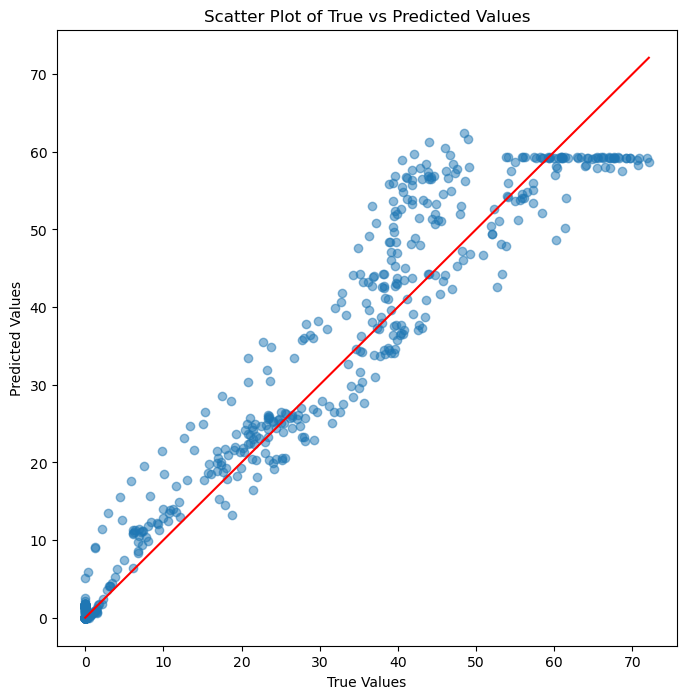

Root Mean Squared Error on Test Data: 2.2742732
Mean Bias Error on Test Data: -0.76826435
Mean Absolute Error on Test Data: 1.2824584
Kling-Gupta efficiency on Test Data: 0.7805115329234456
R2 Score on Test Data: 0.9016182530523864


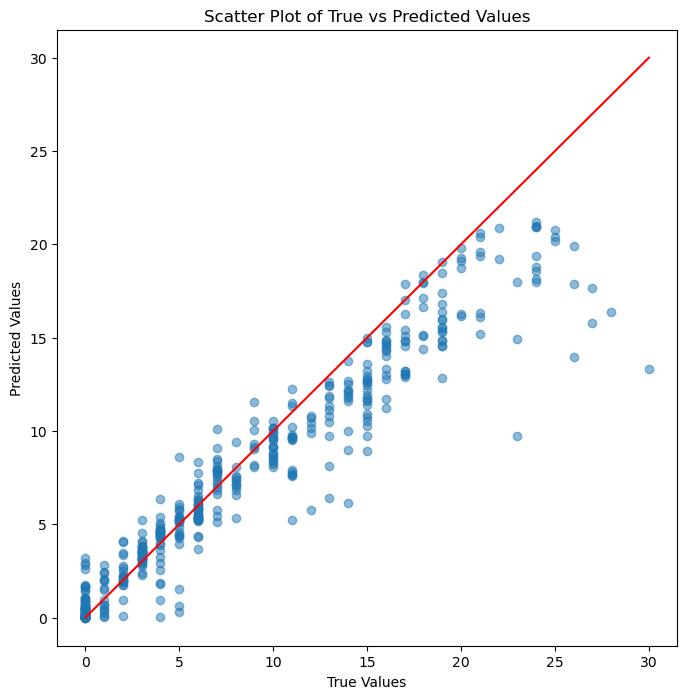

Root Mean Squared Error on Test Data: 8.843374
Mean Bias Error on Test Data: -0.96192634
Mean Absolute Error on Test Data: 5.5037155
Kling-Gupta efficiency on Test Data: 0.9517735100253711
R2 Score on Test Data: 0.9653423218422081


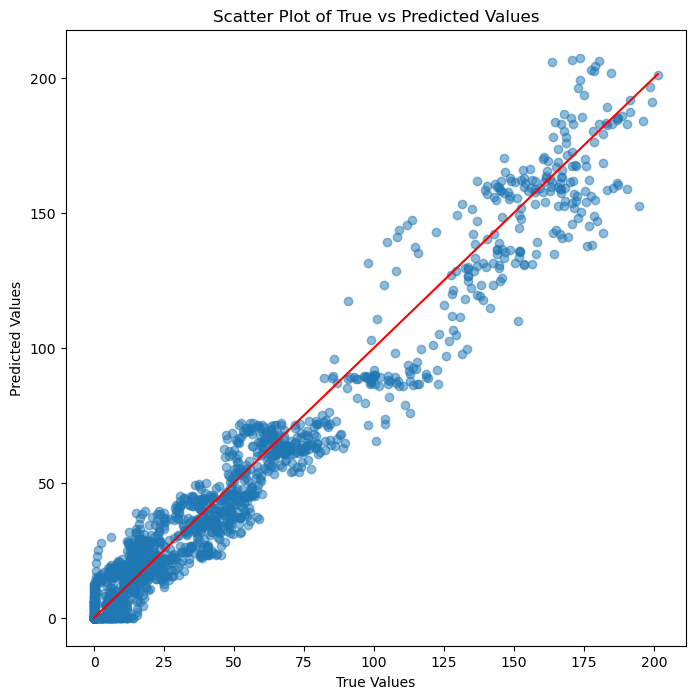

Root Mean Squared Error on Test Data: 1.2619951
Mean Bias Error on Test Data: 0.37846515
Mean Absolute Error on Test Data: 0.7397991
Kling-Gupta efficiency on Test Data: 0.9216264318284499
R2 Score on Test Data: 0.969805916653446


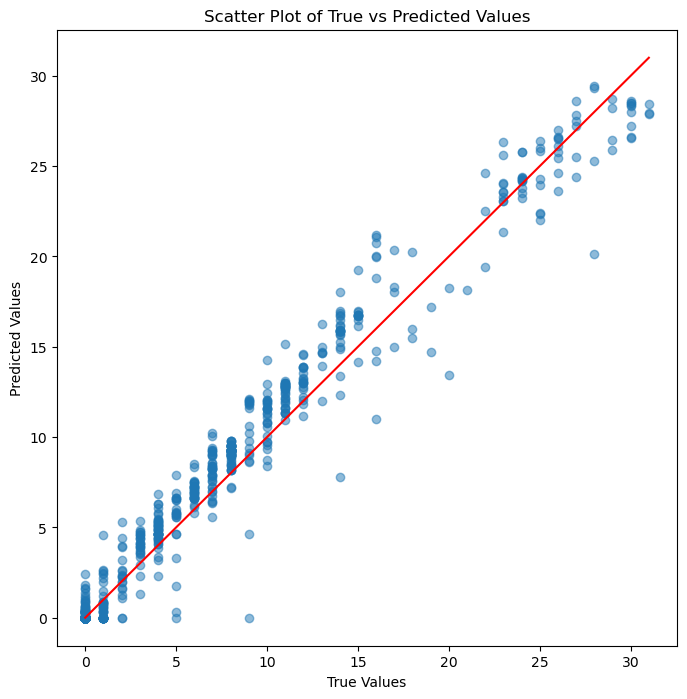

Root Mean Squared Error on Test Data: 5.269494
Mean Bias Error on Test Data: 1.1103039
Mean Absolute Error on Test Data: 3.7002194
Kling-Gupta efficiency on Test Data: 0.9588952379271891
R2 Score on Test Data: 0.9769202394010909


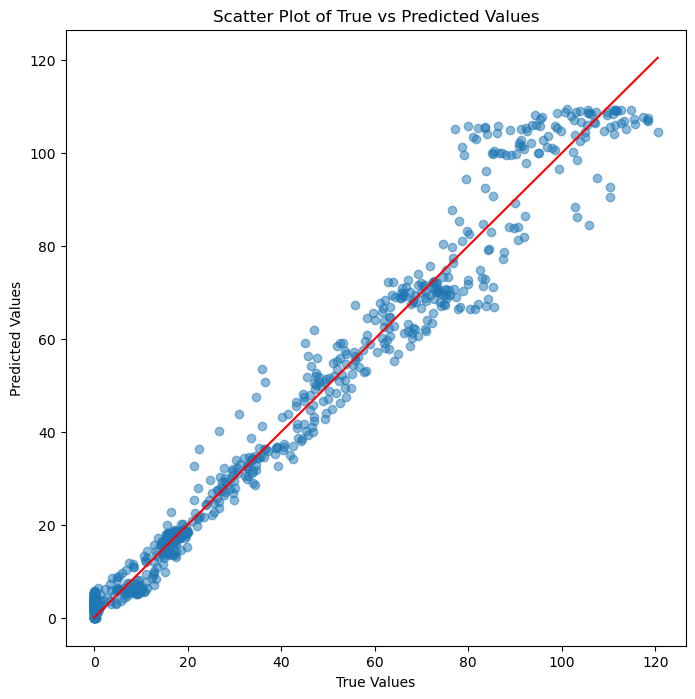

In [9]:
# Processing and evaluating for each snowclass
results_sc = []
for i in range(5):
    result = predict(df_train[i], df_test[i], models[i], var_list[i], ts[i])
    results_sc.append(result)

In [10]:
# Calculate the average RMSE, MAE, MBE over five models
rmse_avg_model = sum(res[0] for res in results_sc)/5
mae_avg_model = sum(res[1] for res in results_sc)/5
mbe_avg_model = sum(res[2] for res in results_sc)/5

print(f"RMSE of averaging all models: {rmse_avg_model}")
print(f"MAE of averaging all models: {mae_avg_model}")
print(f"MBE of averaging all models: {mbe_avg_model}")

RMSE of averaging all models: 4.618254852294922
MAE of averaging all models: 2.968556535243988
MBE of averaging all models: 0.24316950440406798


Overall Root Mean Squared Error on Test Data: 6.5001183
Overall Mean Bias Error on Test Data: -0.048930276
Overall Mean Absolute Error on Test Data: 3.666337
Kling-Gupta efficiency on Test Data: 0.967902265122364
R2 Score on Test Data: 0.9693313843623617


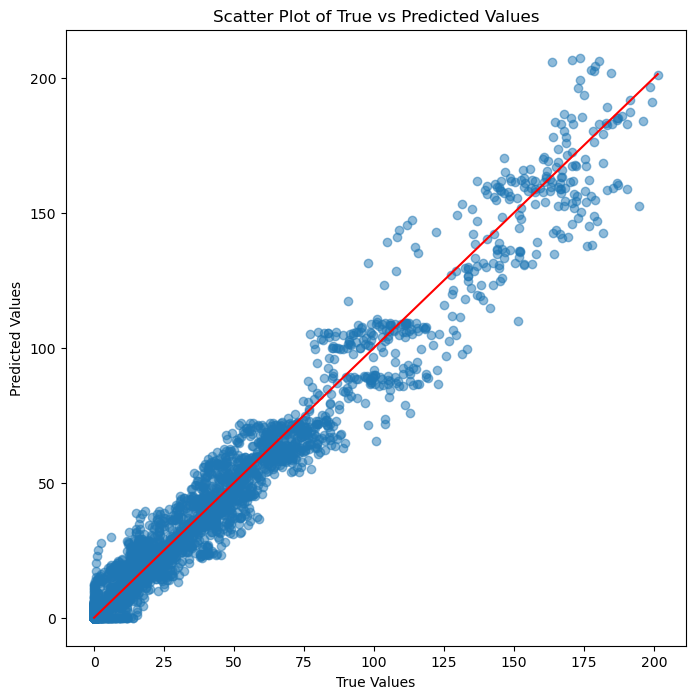

In [11]:
# Concate all the predictions and evaluate the overall performance
compute_overall_perf(results_sc)

## Optional: Multiple models based on countries

#### Optional: Ensemble models and save MLSTM

In [43]:
# Create ensemble models instance
MLSTM_countries = predictLSTM("./models/model_canada.pth")

In [44]:
# Add models for different counties
for country in ['canada', 'switzerland', 'norway', 'US']:
    model_path = f'./models/model_{country}.pth'
    MLSTM_countries.add_country_model(country, model_path)

In [25]:
# Save the model
torch.save(MLSTM_countries, './models/MLSTM_countries.pth')

#### Data Pre-process

In [13]:
# read data
df = pd.read_csv(train_file_path)
df_test = pd.read_csv(test_file_path)

# Split the dataset based on different country
df_norway = df[df['loc'].str.startswith('norway')].copy()
norway_df_test = df_test[df_test['loc'].str.startswith('norway')].copy()

df_canada = df[df['loc'].str.startswith('canada')].copy()
canada_df_test = df_test[df_test['loc'].str.startswith('canada')].copy()

df_swi = df[(df['loc'].str.startswith('gps')) | (df['loc']=='wfj')].copy()
swi_df_test = df[df['loc']=='klo'].copy()

df_us = df[(df['loc'].str.startswith('US'))].copy()
us_df_test = df_test[df_test['loc'].str.startswith('US')].copy()

#### Predict SWE and evaluate models

In [48]:
# Load the MLSTM saved before
MLSTM_countries = torch.load("./models/MLSTM_countries.pth")

In [49]:
# Define variables
var_nor = ['HS', 'precipitation']
df_train = [df_norway, df_canada, df_swi, df_us]
df_test = [norway_df_test, canada_df_test, swi_df_test, us_df_test]
var_list = [var_nor, var, var, var, var]
ts = [30, 30, 30, 30]
models = [MLSTM_countries.country_models[i] for i in ['norway','canada','switzerland','US']]

Root Mean Squared Error on Test Data: 6.2265663
Mean Bias Error on Test Data: -2.6994042
Mean Absolute Error on Test Data: 3.4373248
Kling-Gupta efficiency on Test Data: 0.6986508283805068
R2 Score on Test Data: 0.8742092599845332


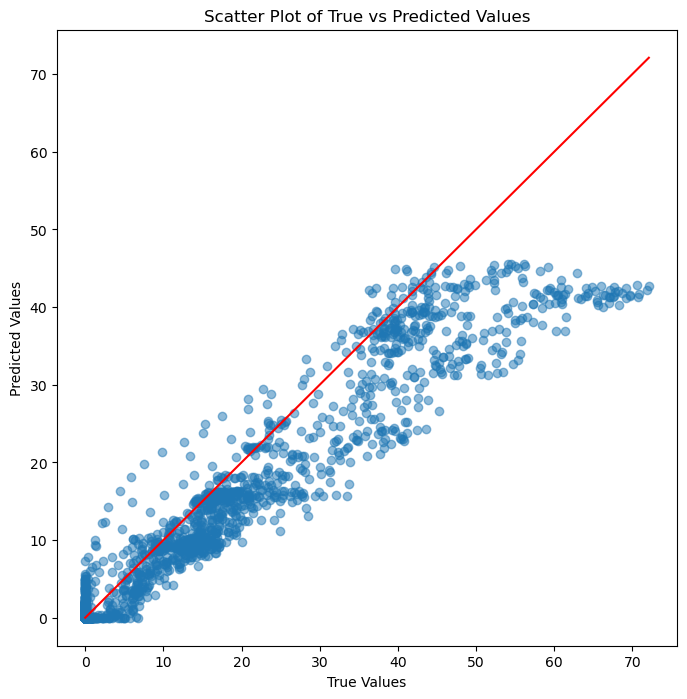

Root Mean Squared Error on Test Data: 8.81022
Mean Bias Error on Test Data: 1.2618157
Mean Absolute Error on Test Data: 6.1625834
Kling-Gupta efficiency on Test Data: 0.9552967853508469
R2 Score on Test Data: 0.9713512684757469


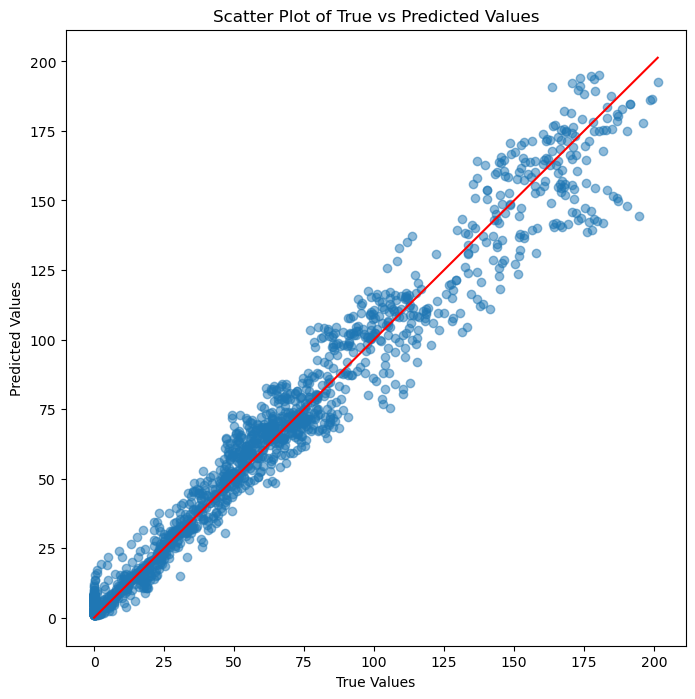

Root Mean Squared Error on Test Data: 4.170932
Mean Bias Error on Test Data: 2.08767
Mean Absolute Error on Test Data: 2.8822389
Kling-Gupta efficiency on Test Data: 0.795107726793195
R2 Score on Test Data: 0.8910388479501428


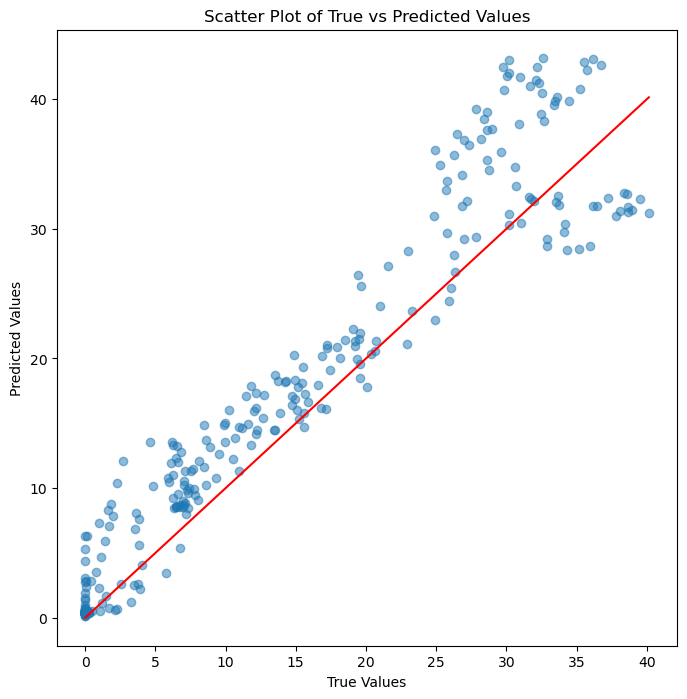

Root Mean Squared Error on Test Data: 1.5240346
Mean Bias Error on Test Data: -0.09101558
Mean Absolute Error on Test Data: 0.84198993
Kling-Gupta efficiency on Test Data: 0.9142837996439451
R2 Score on Test Data: 0.9552915620863951


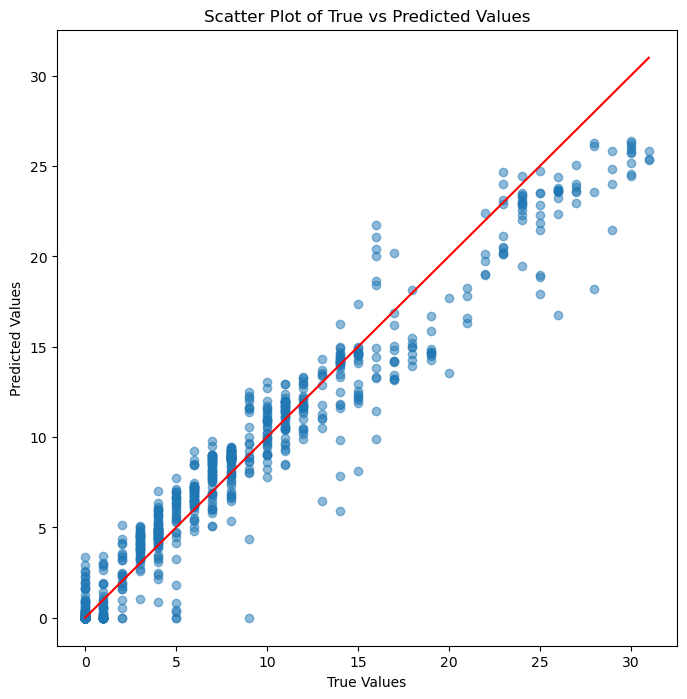

In [50]:
# Processing and evaluating for each country
results_countries = []
for i in range(4):
    result = predict(df_train[i], df_test[i], models[i], var_list[i], ts[i])
    results_countries.append(result)

In [61]:
# Calculate the average RMSE, MAE, MBE over five models
rmse_avg_model = sum(res[0] for res in results_countries)/5
mae_avg_model = sum(res[1] for res in results_countries)/5
mbe_avg_model = sum(res[2] for res in results_countries)/5

print(f"RMSE of averaging all models: {rmse_avg_model}")
print(f"MAE of averaging all models: {mae_avg_model}")
print(f"MBE of averaging all models: {mbe_avg_model}")

RMSE of averaging all models: 4.1463505029678345
MAE of averaging all models: 2.6648273825645448
MBE of averaging all models: 0.11181318759918213


Overall Root Mean Squared Error on Test Data: 6.441055
Overall Mean Bias Error on Test Data: -0.56847084
Overall Mean Absolute Error on Test Data: 3.679185
Kling-Gupta efficiency on Test Data: 0.9633961729365913
R2 Score on Test Data: 0.9697248787094894


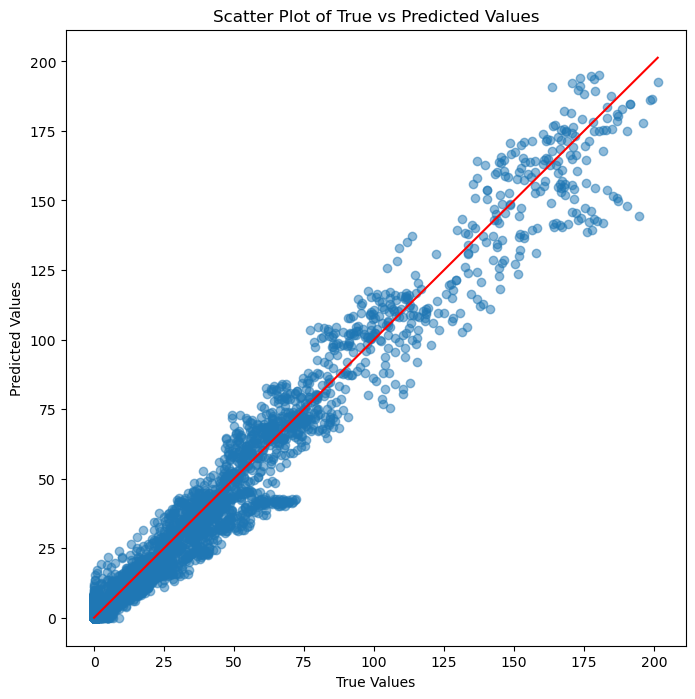

In [51]:
# Concate all the predictions and evaluate the overall performance
compute_overall_perf(results_countries)

# Single global model

#### Predict SWE and evaluate models

In [11]:
# Create ensemble models
SLSTM = predictLSTM("./models/global_model.pth",type='general')

In [12]:
# Define variables
df_train = [df, df, df, df, df]
df_test = [df_1_test, df_2_test, df_3_test, df_5_test, df_6_test]
var_list = [var, var, var, var, var]
ts = [30, 30, 30, 30, 30]
models = [SLSTM.model for i in [1, 2, 3, 5, 6]]


Root Mean Squared Error on Test Data: 6.4379883
Mean Bias Error on Test Data: -1.9119678
Mean Absolute Error on Test Data: 4.3377776
Kling-Gupta efficiency on Test Data: 0.8205575432878506
R2 Score on Test Data: 0.9175952266551421


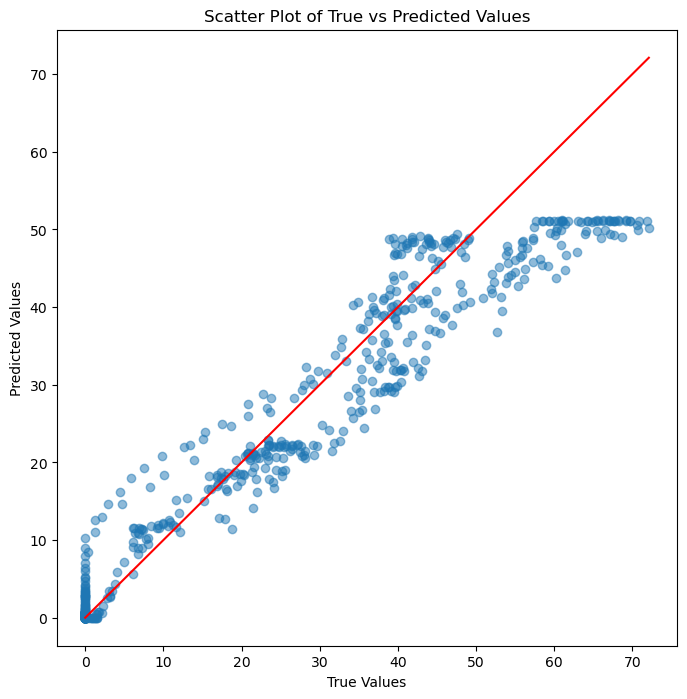

Root Mean Squared Error on Test Data: 1.6704956
Mean Bias Error on Test Data: -0.6017023
Mean Absolute Error on Test Data: 0.99266464
Kling-Gupta efficiency on Test Data: 0.8127370128091127
R2 Score on Test Data: 0.9329217117520169


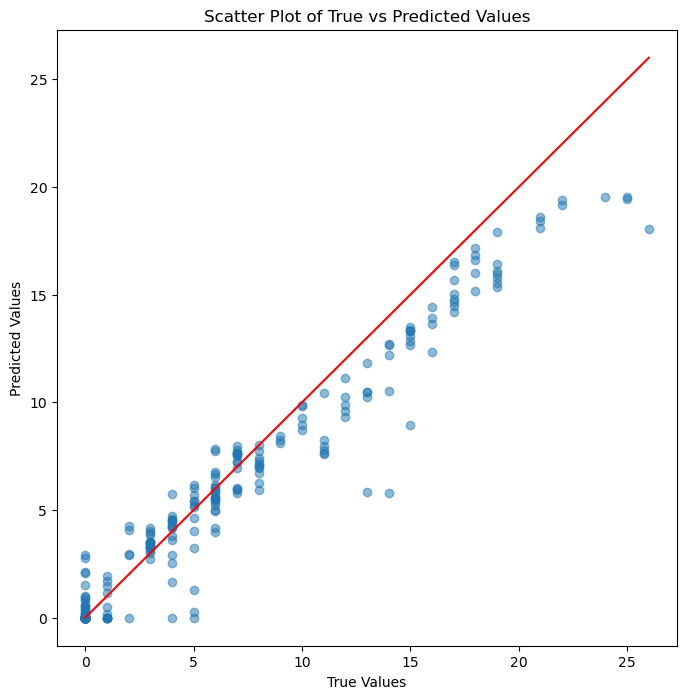

Root Mean Squared Error on Test Data: 8.493742
Mean Bias Error on Test Data: -3.3250275
Mean Absolute Error on Test Data: 5.128424
Kling-Gupta efficiency on Test Data: 0.8975980585116091
R2 Score on Test Data: 0.9693651997126975


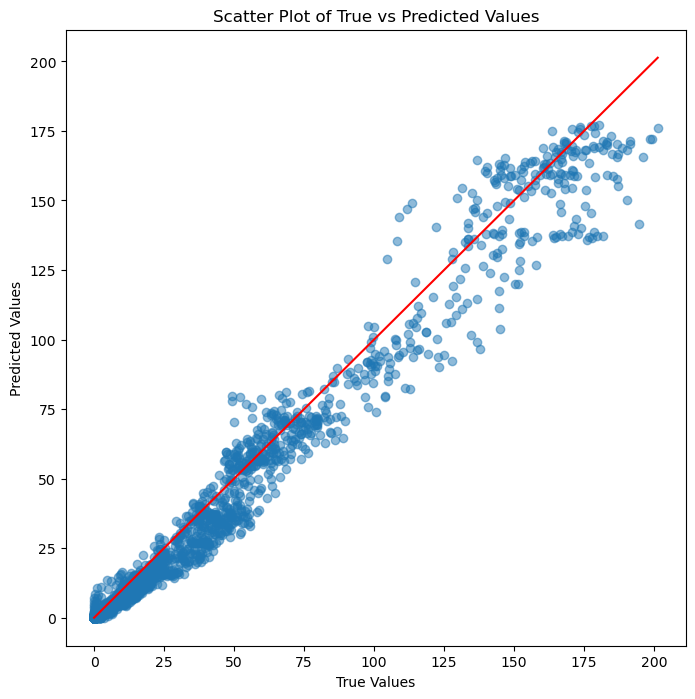

Root Mean Squared Error on Test Data: 1.1767589
Mean Bias Error on Test Data: -0.10072318
Mean Absolute Error on Test Data: 0.5497
Kling-Gupta efficiency on Test Data: 0.9510235539127366
R2 Score on Test Data: 0.9746678475404456


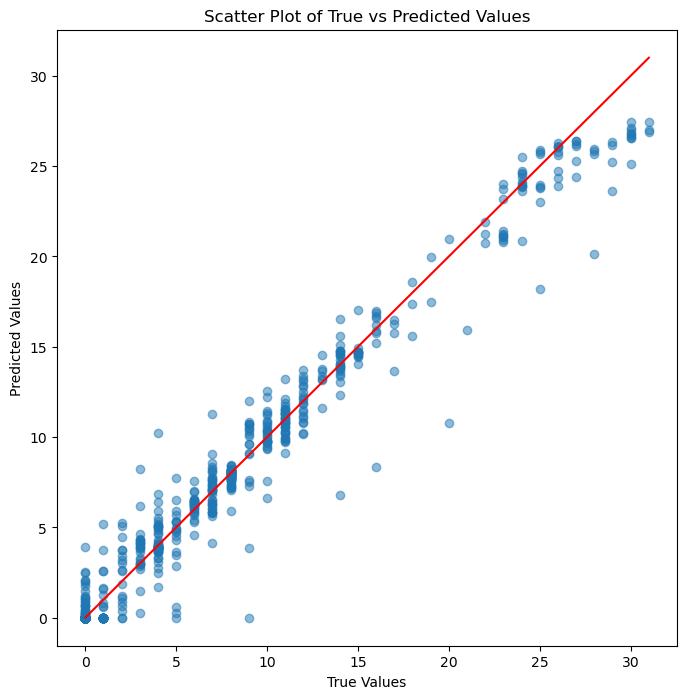

Root Mean Squared Error on Test Data: 7.114582
Mean Bias Error on Test Data: -1.6822733
Mean Absolute Error on Test Data: 4.5521073
Kling-Gupta efficiency on Test Data: 0.863846323122884
R2 Score on Test Data: 0.9579280913558244


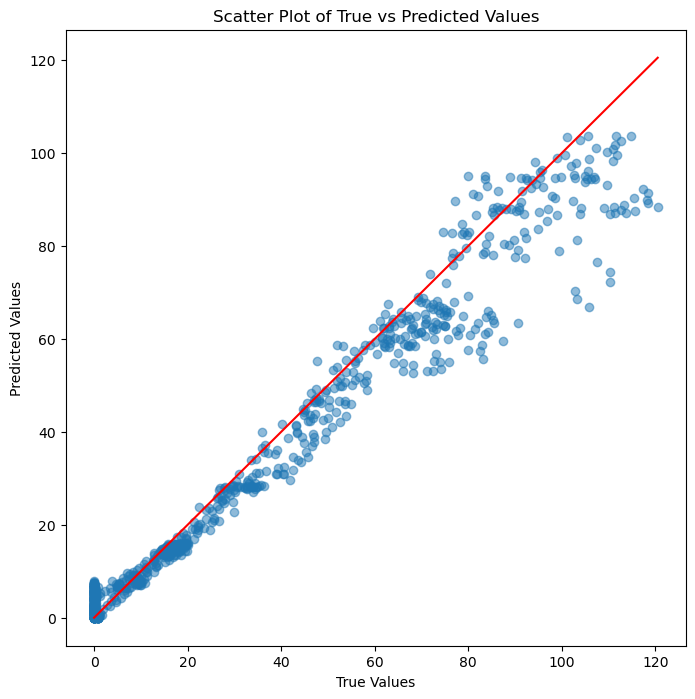

In [14]:
# Processing and evaluating for each snowclass
results_slstm = []
for i in range(5):
    result = predict(df_train[i], df_test[i], models[i], var_list[i], ts[i])
    results_slstm.append(result)

In [59]:
# Calculate the average RMSE, MAE, MBE over five models
rmse_avg_model = sum(res[0] for res in results_slstm)/5
mae_avg_model = sum(res[1] for res in results_slstm)/5
mbe_avg_model = sum(res[2] for res in results_slstm)/5

print(f"RMSE of averaging all models: {rmse_avg_model}")
print(f"MAE of averaging all models: {mae_avg_model}")
print(f"MBE of averaging all models: {mbe_avg_model}")

RMSE of averaging all models: 4.986572790145874
MAE of averaging all models: 3.122534704208374
MBE of averaging all models: -1.5311872765421868


Overall Root Mean Squared Error on Test Data: 6.818337
Overall Mean Bias Error on Test Data: -2.0498843
Overall Mean Absolute Error on Test Data: 3.7961342
Kling-Gupta efficiency on Test Data: 0.8952061203097683
R2 Score on Test Data: 0.9686067914515631


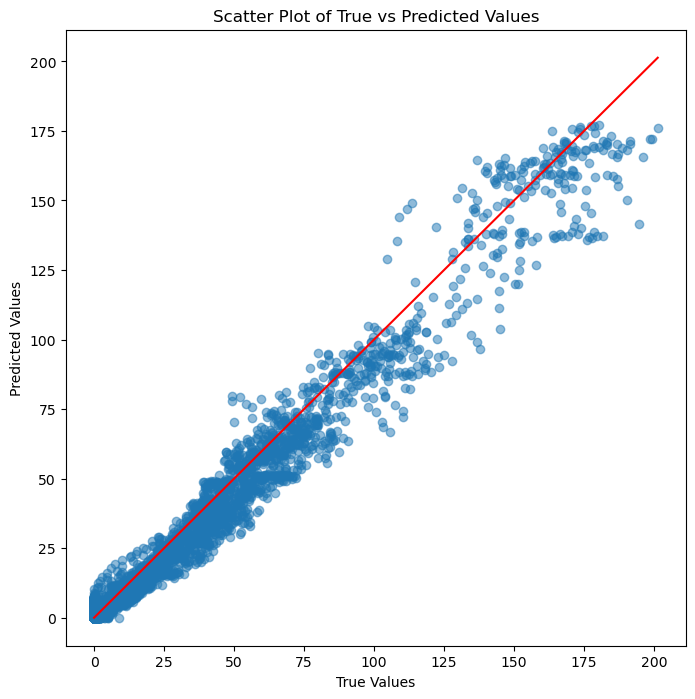

In [60]:
# Concate all the predictions and evaluate performance
compute_overall_perf(results_slstm)

# Plot time series to compare SLSTM and MLSTM

Plot the time series of station - norway_121420 and compare the result from MLSTM and SLSTM.

In [16]:
# Read data
df = pd.read_csv(train_file_path)
df_test = pd.read_csv(test_file_path)

df_norway_850 = df_test[df_test['loc'] == 'norway_121420'].copy()
df_norway_850 = df_norway_850.sort_values(by="date")
df_norway_850.reset_index(drop=True, inplace=True)

Root Mean Squared Error on Test Data: 4.0760207
Mean Bias Error on Test Data: -1.0526503
Mean Absolute Error on Test Data: 2.9226031
Kling-Gupta efficiency on Test Data: 0.9000946441425396
R2 Score on Test Data: 0.9746248995912692


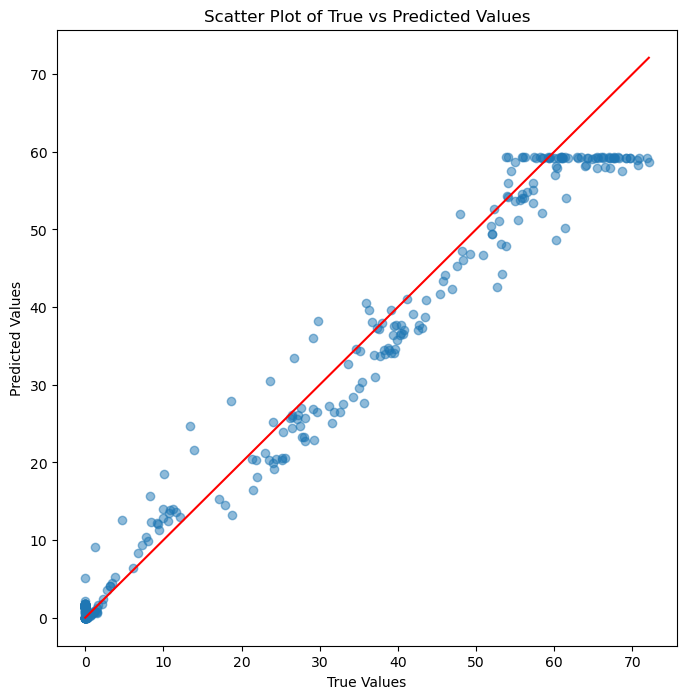

In [17]:
# Get the prediction from MLSTM
dataset_norway_850 = sweDataset(df=df_1, df_test=df_norway_850, var=var, ts=14)
_,_,test_loader_nor = dataset_norway_850.get_data_loaders()
results_mlstm = tool.evaluate_model(test_loader_nor, MLSTM_sc.snowclass_models[1], dataset_norway_850)

Root Mean Squared Error on Test Data: 8.122664
Mean Bias Error on Test Data: -4.6577344
Mean Absolute Error on Test Data: 6.0332375
Kling-Gupta efficiency on Test Data: 0.7114787014916488
R2 Score on Test Data: 0.8991415919775392


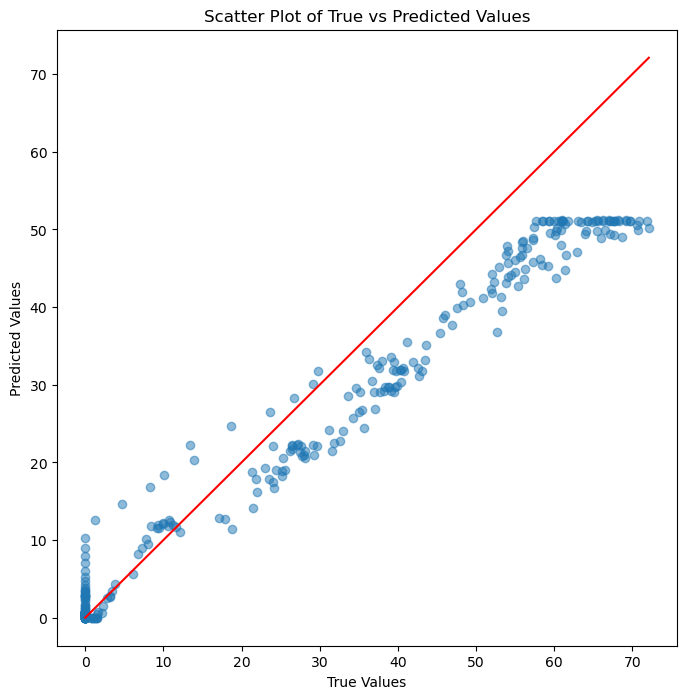

In [26]:
# Get the prediction from SLSTM
dataset_norway_850 = sweDataset(df=df, df_test=df_norway_850, var=var, ts=30)
_,_,test_loader_nor = dataset_norway_850.get_data_loaders()
results_slstm = tool.evaluate_model(test_loader_nor, SLSTM.model, dataset_norway_850)

In [27]:
dates = df_norway_850['date']

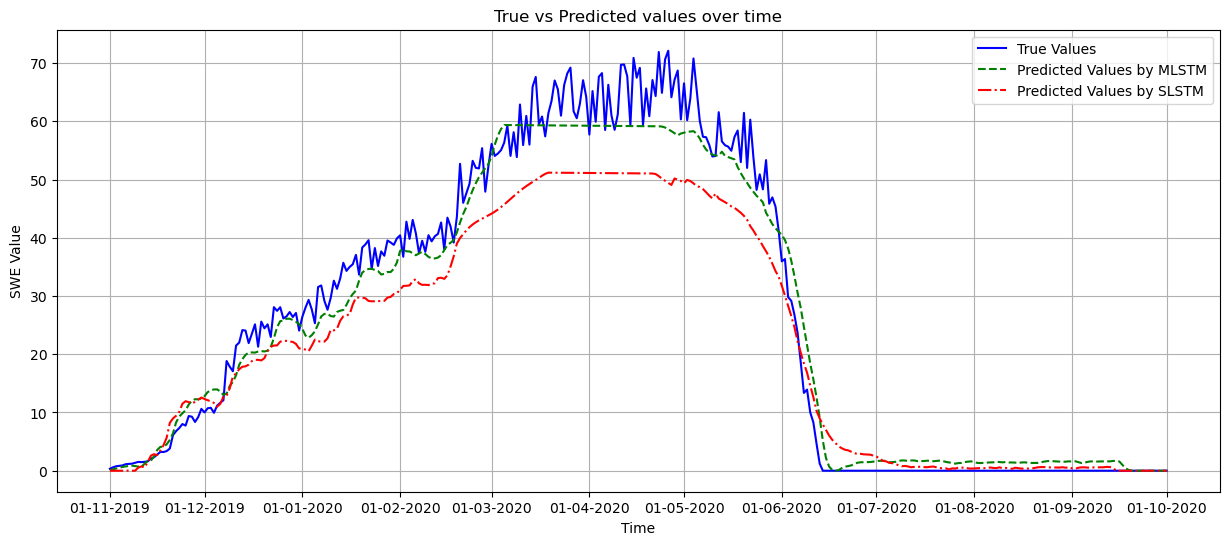

In [28]:
tool.plot_time_series(results_mlstm[5][-len(results_slstm[6]):], results_mlstm[6][-len(results_slstm[6]):], results_slstm[6], dates[-len(results_slstm[6]):])

# Optional: Ensemble Training by averaging the results from multi-models system

This method tried to ensemble all the snow class models, and take average over all the predictions from different models to get the final output. But the performance does not look great.

In [62]:
def average_prediction(ensemble_models, df=df, df_test=df_test):
    """
    Compute the average prediction of ensemble models on test data.

    :param ensemble_models: A dictionary where stored the trained models.
    :type ensemble_models: dict
    :param df: Training dataframe with columns required for modeling, default is 'df'.
    :type df: pd.DataFrame, optional
    :param df_test: Test dataframe with columns required for modeling, default is 'df_test'.
    :type df_test: pd.DataFrame, optional

    :return: tuple of (y_true, avg_prediction).y_true - the observed valued, 
             avg_prediction - averaged predictions
    :rtype: tuple(np.array, np.array)
    """
    total_predictions = []

    # Get the predictions for all models
    for i in [1,2,3,5,6]:
        if i != 3 :
            dataset=sweDataset(df=df, df_test=df_test, var=['HS'], ts=30)
        else:
            dataset=sweDataset(df=df, df_test=df_test, var=['HS','temperature','precipitation'], ts=30)
            
        _,_,test_loader = dataset.get_data_loaders()
        _, _, _, _, _, y_true, prediction = tool.evaluate_model(test_loader, ensemble_models[i], dataset)
        total_predictions.append(prediction)
        
    # Average the results   
    min_length = min([len(prediction) for prediction in total_predictions])
    truncated_predictions = [prediction[-min_length:] for prediction in total_predictions]
    avg_prediction = sum(truncated_predictions) / len(truncated_predictions)

    y_true = y_true[-min_length:]
    
    return y_true, avg_prediction

Root Mean Squared Error on Test Data: 11.090474
Mean Bias Error on Test Data: -6.194727
Mean Absolute Error on Test Data: 6.7895064
Kling-Gupta efficiency on Test Data: 0.7462580784127262
R2 Score on Test Data: 0.917205737600752


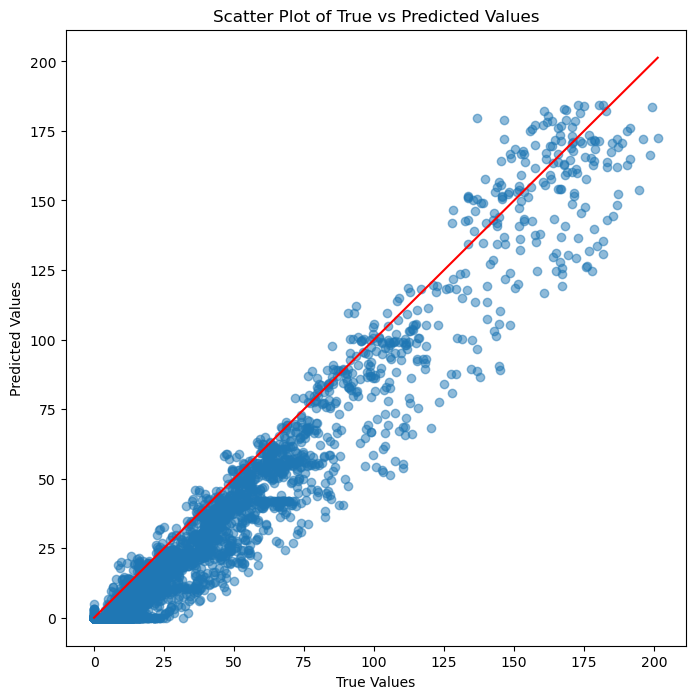

Root Mean Squared Error on Test Data: 16.844463
Mean Bias Error on Test Data: -0.49884662
Mean Absolute Error on Test Data: 9.745414
Kling-Gupta efficiency on Test Data: 0.7436443469195466
R2 Score on Test Data: 0.8087170909584624


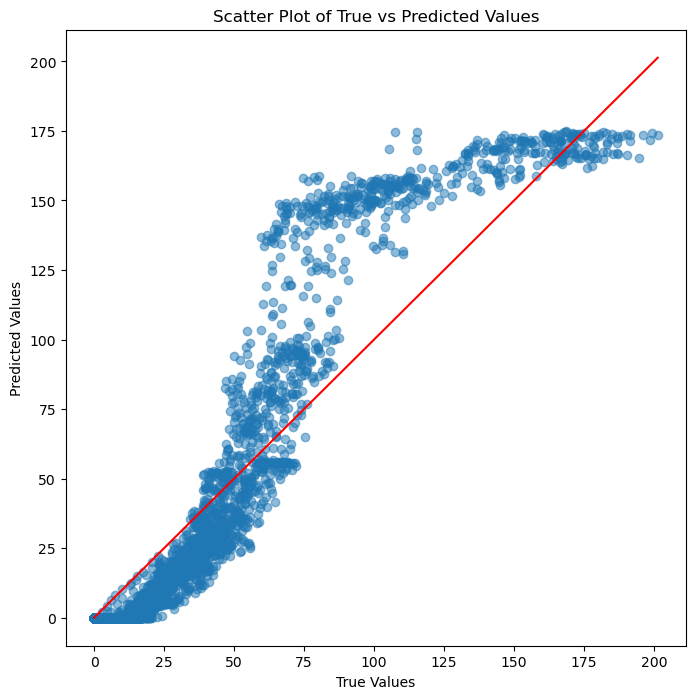

Root Mean Squared Error on Test Data: 68.899994
Mean Bias Error on Test Data: 26.93204
Mean Absolute Error on Test Data: 56.02487
Kling-Gupta efficiency on Test Data: -0.5606393272891443
R2 Score on Test Data: -2.3710403935623527


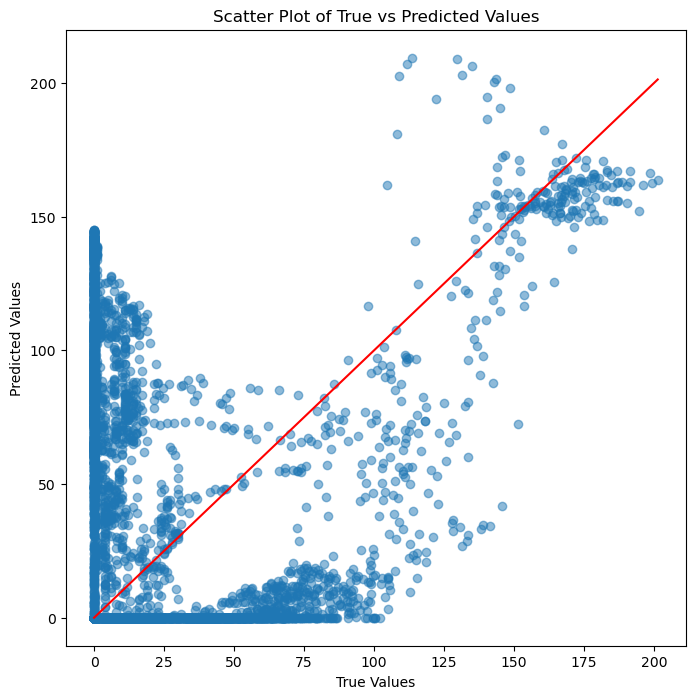

Root Mean Squared Error on Test Data: 12.501545
Mean Bias Error on Test Data: -4.576488
Mean Absolute Error on Test Data: 5.73141
Kling-Gupta efficiency on Test Data: 0.7412341833213947
R2 Score on Test Data: 0.8944070646815482


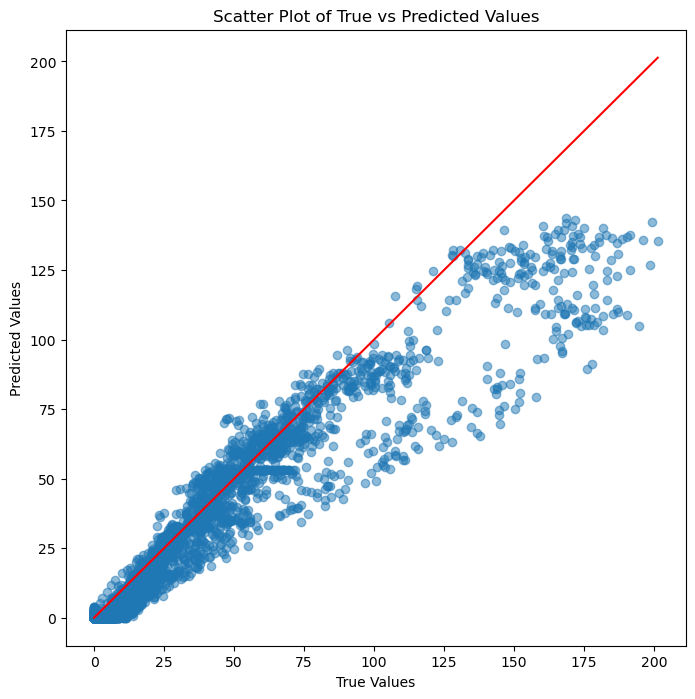

Root Mean Squared Error on Test Data: 14.380737
Mean Bias Error on Test Data: -6.409295
Mean Absolute Error on Test Data: 8.799206
Kling-Gupta efficiency on Test Data: 0.6168765547850258
R2 Score on Test Data: 0.8603081766258719


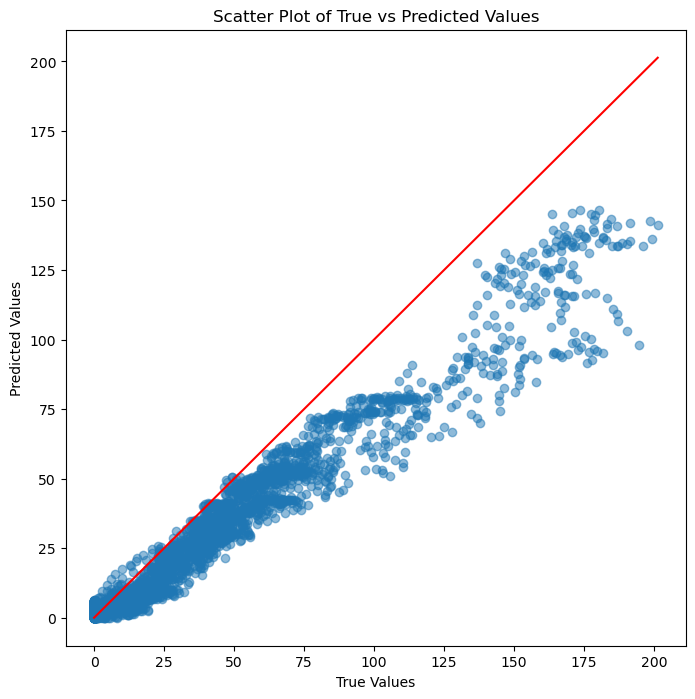

In [63]:
y_true, avg_prediction = average_prediction(MLSTM_sc.snowclass_models, df=df, df_test=df_test)

In [68]:
rmse_test = np.sqrt(mean_squared_error(y_true, avg_prediction))
kge_test = tool.kge(y_true.reshape(-1), avg_prediction.reshape(-1))
mae_test = mean_absolute_error(y_true, avg_prediction)
r2_test = r2_score(y_true, avg_prediction)
mbe_test = tool.mean_bias_error(y_true, avg_prediction) 

print('Root Mean Squared Error on Test Data:', rmse_test)
print('Mean Bias Error on Test Data:', mbe_test)
print('Mean Absolute Error on Test Data:', mae_test)
print('Kling-Gupta efficiency on Test Data:', kge_test)
print('R2 Score on Test Data:', r2_test)

Root Mean Squared Error on Test Data: 18.29045
Mean Bias Error on Test Data: 0.7420588
Mean Absolute Error on Test Data: 13.559438
Kling-Gupta efficiency on Test Data: 0.6837638819272492
R2 Score on Test Data: 0.7751257048339593
